## Import packages

In [26]:
import osmnx as ox, networkx as nx, numpy as np, pandas as pd, geopandas as gpd, random, math
import matplotlib.pyplot as plt, matplotlib.colors as mcolors
from shapely.geometry import Point
from shapely.ops import transform
from scipy.spatial import cKDTree
from itertools import cycle
from pathlib import Path
from collections import defaultdict
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
import pyproj
import folium
from folium import GeoJson, CircleMarker, Marker, PolyLine, Icon, DivIcon
from folium.plugins import MarkerCluster
from matplotlib.lines import Line2D

## Load data

In [27]:
def cargar_geojson(nombre_archivo, directorio_base='../../../../data/delivetter'):
    """
    Carga un archivo GeoJSON específico y devuelve un GeoDataFrame.
    
    Args:
        nombre_archivo (str): Nombre del archivo GeoJSON (ej. 'barris.geojson').
        directorio_base (str): Ruta relativa al directorio donde se encuentra el archivo.
                              Por defecto: '../../data/delivetter'.
    
    Returns:
        gpd.GeoDataFrame: GeoDataFrame con los datos del archivo.
        None: Si el archivo no existe o hay un error.
    """
    try:
        ruta = Path(directorio_base) / nombre_archivo
        
        if not ruta.exists():
            raise FileNotFoundError(f"File not found: {ruta.absolute()}")
        
        gdf = gpd.read_file(ruta)
        print(f"✅ '{nombre_archivo}' successfully loaded ({len(gdf)} records)")
        return gdf
    
    except Exception as e:
        print(f"❌ Error loading '{nombre_archivo}': {str(e)}")
    
barrios = cargar_geojson('barris.geojson')
catastro = cargar_geojson('catastro.geojson')
puntos_carga = cargar_geojson('puntosCID.geojson')

✅ 'barris.geojson' successfully loaded (88 records)
✅ 'catastro.geojson' successfully loaded (36346 records)
✅ 'puntosCID.geojson' successfully loaded (885 records)


## Graph request 

In [28]:
def get_graph(request):
    shp_neighbourhood = barrios[barrios["nombre"].str.strip().str.upper() == request.strip().upper()]
    if len(shp_neighbourhood) != 1:
        shp_neighbourhood = barrios[barrios["nombre"].str.upper().str.contains(request.strip().upper())]
    while len(shp_neighbourhood) != 1:
        request = input("Please, introduce a valid neighbourhood: ")
        shp_neighbourhood = barrios[barrios["nombre"].str.strip().str.upper() == request.strip().upper()]
        if len(shp_neighbourhood) == 1:
            break
        shp_neighbourhood = barrios[barrios["nombre"].str.upper().str.contains(request.strip().upper())]

    barrio = shp_neighbourhood["nombre"].values[0]
    shp_zone = shp_neighbourhood.geometry.values[0]
    shp_loading_points = puntos_carga[puntos_carga.intersects(shp_zone)]
    shp_bajos = catastro[catastro.intersects(shp_zone)]

    G = ox.graph_from_polygon(
        shp_zone,
        network_type="all_public",
        simplify=False,
        retain_all=False,
        truncate_by_edge=True
    )

    not_highway = ['elevator', 'busway', 'corridor', 'unclassified', 'services', 'cycleway', 'steps', 'service']
    allowed_vehicle = ['motorway', 'residential', 'secondary', 'living_street', 'primary_link', 'primary', 'tertiary', 'trunk', 'service', 'tertiary_link', 'trunk_link', 'secondary_link', 'motorway_link', 'road']
    allowed_pedestrian = ['pedestrian', 'footway', 'path', 'track', 'bridleway', 'living_street', 'residential']

    edges_to_remove = [(u, v, k) for u, v, k, data in G.edges(keys=True, data=True)
                       if data.get('highway') in not_highway or data.get('access') in ['private', 'no', 'customers']]
    G.remove_edges_from(edges_to_remove)

    G_vehicle = G.copy()
    G_pedestrian = G.copy()

    edges_to_remove_vehicle = [(u, v, k) for u, v, k, data in G_vehicle.edges(keys=True, data=True)
                                if data.get('highway') not in allowed_vehicle]
    G_vehicle.remove_edges_from(edges_to_remove_vehicle)

    edges_to_remove_pedestrian = [(u, v, k) for u, v, k, data in G_pedestrian.edges(keys=True, data=True)
                                  if data.get('highway') not in allowed_pedestrian]
    G_pedestrian.remove_edges_from(edges_to_remove_pedestrian)

    for graph in [G_vehicle, G_pedestrian]:
        nodes_to_remove = [node for node in graph.nodes if graph.degree(node) == 0]
        graph.remove_nodes_from(nodes_to_remove)

    G_vehicle = G_vehicle.subgraph(max(nx.weakly_connected_components(G_vehicle), key=len)).copy()
    G_pedestrian = G_pedestrian.subgraph(max(nx.weakly_connected_components(G_pedestrian), key=len)).copy()

    print(f"Graph for {barrio}:")
    print(f"Vehicle graph: {len(G_vehicle.nodes)} nodes, {len(G_vehicle.edges)} edges")
    print(f"Pedestrian graph: {len(G_pedestrian.nodes)} nodes, {len(G_pedestrian.edges)} edges")
    print(f"Loading points: {len(shp_loading_points)} points")
    print(f"Warehouse and store: {len(shp_bajos)} points")

    return barrio, G_vehicle, G_pedestrian, shp_zone, shp_loading_points, shp_bajos

def graph_map(G_vehicle, G_pedestrian, shp_zone, shp_loading_points, bajos):
    # --- 1. Visualización de grafos en matplotlib ---
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    axes[0].set_aspect('equal', 'box')
    axes[1].set_aspect('equal', 'box')
    ox.plot_graph(G_vehicle, ax=axes[0], node_size=3, node_color='green', 
                  edge_linewidth=0.5, edge_color='blue', bgcolor="white", show=False)
    axes[0].set_title("Drive graph")

    ox.plot_graph(G_pedestrian, ax=axes[1], node_size=3, node_color='green', 
                  edge_linewidth=0.5, edge_color='red', bgcolor="white", show=False)
    axes[1].set_title("Pedestrian graph")
    plt.tight_layout()
    plt.show()

    # --- 2. Mapa interactivo en Folium ---

    mapa = folium.Map(location=[shp_zone.centroid.y, shp_zone.centroid.x], zoom_start=16)

    gdf_edges_vehicle = ox.graph_to_gdfs(G_vehicle, nodes=False, edges=True)
    gdf_edges_pedestrian = ox.graph_to_gdfs(G_pedestrian, nodes=False, edges=True)

    bajos_in_zone = bajos[bajos.intersects(shp_zone)]

    # --- 2.1 Añadir zona del barrio ---
    folium.GeoJson(
        shp_zone,
        style_function=lambda feature: {
            "color": "limegreen", "weight": 6, "fill": True,
            "fillColor": "limegreen", "fillOpacity": 0.2
        }
    ).add_to(mapa)

    # --- 2.2 Función para añadir aristas ---
    def add_edges(gdf_edges, color, group_name):
        for _, row in gdf_edges.iterrows():
            if row.geometry.geom_type == "LineString":
                tooltip = folium.Tooltip(
                    f"<b>Type:</b> {row.get('highway', 'N/A')}<br>"
                    f"<b>Name:</b> {row.get('name', 'No name')}<br>"
                    f"<b>Length:</b> {round(row.get('length', 0), 1)} m"
                )
                folium.GeoJson(
                    row.geometry,
                    name=group_name,
                    style_function=lambda feature, col=color: {'color': col, 'weight': 2, 'opacity': 1},
                    tooltip=tooltip
                ).add_to(mapa)

    add_edges(gdf_edges_pedestrian, "red", "Pedestrians")
    add_edges(gdf_edges_vehicle, "blue", "Vehicles")

    # --- 2.3 Añadir puntos de carga ---
    for _, row in shp_loading_points.iterrows():
        folium.CircleMarker(
            location=[row.geometry.centroid.y, row.geometry.centroid.x],
            radius=6, color="black", fill=True, fill_color="orange", fill_opacity=1,
            popup=row.get("NOMBRE", "Loading Point")
        ).add_to(mapa)

    # --- 2.4 Añadir puntos bajos (almacenes y comercios) ---
    for _, row in bajos_in_zone.iterrows():
        if not row['Almacen'] and not row['Comercio']:
            continue
        centroide = row.geometry.centroid
        if row['Almacen'] and row['Comercio']:
            fill_color, label = 'black', 'Warehouse & Store'
        elif row['Almacen']:
            fill_color, label = 'purple', 'Warehouse'
        else:
            fill_color, label = 'lightblue', 'Store'
        folium.CircleMarker(
            location=[centroide.y, centroide.x],
            radius=6, color='black', fill=True, fill_color=fill_color, fill_opacity=1,
            popup=label
        ).add_to(mapa)

    # --- 2.5 Añadir leyenda personalizada ---
    legend_html = '''
    <div style="position: fixed; bottom: 50px; left: 50px; width: 250px; height: 140px;
                background-color: white; z-index:9999; font-size:13px; border:1px solid grey; 
                border-radius: 5px; padding: 8px; box-shadow: 2px 2px 5px rgba(0,0,0,0.2);">
        <b style="font-size:14px;">Legend</b><br>
        <i class="fa fa-circle" style="color:black; margin-right:5px;"></i> Warehouse & Store<br>
        <i class="fa fa-circle" style="color:orange; margin-right:5px;"></i> CiD Point<br>
        <i class="fa fa-circle" style="color:purple; margin-right:5px;"></i> Warehouse<br>
        <i class="fa fa-circle" style="color:lightblue; margin-right:5px;"></i> Store (delivery)<br>
        <i class="fa fa-square" style="color:limegreen; margin-right:5px;"></i> Neighborhood Boundary
    </div>'''
    mapa.get_root().html.add_child(folium.Element(legend_html))

    return mapa



### 🏙️ NEIGHBORHOODS WITH AT LEAST ONE CiD POINT

| AIORA                | ARRANCAPINS          | BENICALAP               | BENIFERRI                |
|----------------------|----------------------|--------------------------|--------------------------|
| BENIFARAIG           | BENIMACLET           | BENIMAMET               | CABANYAL-CANYAMELAR      |
| CAMI DE VERA         | CAMI FONDO           | CAMI REAL               | CAMPANAR                 |
| CASTELLAR-L'OLIVERAL | CIUTAT DE LES ARTS I DE LES CIENCIES | CIUTAT FALLERA | CIUTAT JARDI             |
| CIUTAT UNIVERSITARIA | EL BOTANIC           | EL CALVARI              | EL FORN D'ALCEDO         |
| EL GRAU              | EL MERCAT            | EL PALMAR               | EL PERELLONET            |
| EL PLA DEL REMEI     | EN CORTS             | EXPOSICIO               | FAVARA                   |
| JAUME ROIG           | LA CARRASCA          | LA CREU COBERTA         | LA CREU DEL GRAU         |
| LA FONTETA S.LLUIS   | LA FONTSANTA         | LA GRAN VIA             | LA LLUM                  |
| LA MALVA-ROSA        | LA PETXINA           | LA PUNTA                | LA RAIOSA                |
| LA ROQUETA           | LA SEU               | LA TORRE                | LA VEGA BAIXA            |
| LES TENDETES         | L'HORT DE SENABRE    | L'ILLA PERDUDA          | L'AMISTAT                |
| MALILLA              | MARXALENES           | MASSARROJOS             | MESTALLA                 |
| MONTOLIVET           | MORVEDRE             | NATZARET                | NOU MOLES                |
| PATRAIX              | PENYA-ROJA           | PINEDO                  | RUSSAFA                  |
| SAFRANAR             | SANT ANTONI          | SANT FRANCESC           | SANT ISIDRE              |
| SANT LLORENS         | SANT MARCEL.LI       | SANT PAU                | SOTERNES                 |
| TORMOS               | TORREFIEL            | TRINITAT                | TRES FORQUES             |
| VARA DE QUART        | ALBORS               | BETERO                  |                          |



Graph for SANT FRANCESC:
Vehicle graph: 427 nodes, 466 edges
Pedestrian graph: 1315 nodes, 2850 edges
Loading points: 13 points
Warehouse and store: 511 points


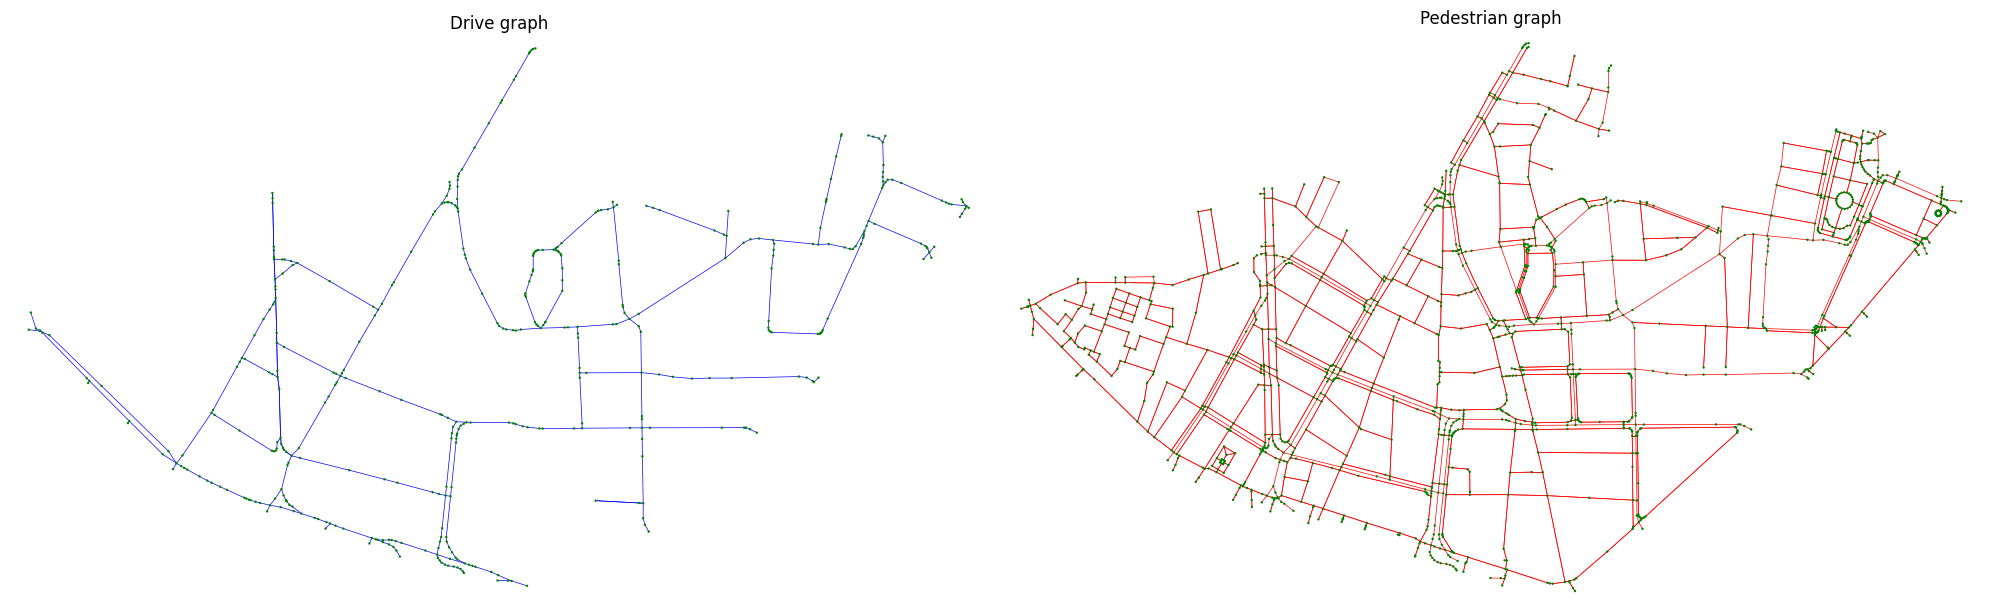

In [29]:
barrio, G_drive, G_walk, shp_zone, shp_loading_points, shp_bajos= get_graph('SANT FRANCESC')
graph_map(G_drive, G_walk, shp_zone, shp_loading_points, shp_bajos)

## Supergraph building

In [30]:
# --- 1. Crear supergrafo vacío y añadir nodos ---
G_super = nx.MultiDiGraph()
G_super.add_nodes_from(G_drive.nodes(data=True))
G_super.add_nodes_from(G_walk.nodes(data=True))

# --- 2. Función para añadir o fusionar aristas con múltiples modos ---
def add_or_merge_edge(G, u, v, key, data, mode):
    data = data.copy()
    modos = data.get('mode', [])
    if not isinstance(modos, list):
        modos = [modos]
    if mode not in modos:
        modos.append(mode)
    data['mode'] = modos

    # Fusionar si existe arista con misma geometría
    if G.has_edge(u, v):
        for k_exist, existing in G[u][v].items():
            if existing.get('geometry') == data.get('geometry'):
                exist_mod = existing.get('mode', [])
                if not isinstance(exist_mod, list):
                    exist_mod = [exist_mod]
                for m in modos:
                    if m not in exist_mod:
                        exist_mod.append(m)
                existing['mode'] = exist_mod
                return
    G.add_edge(u, v, key=key, **data)

# Añadir aristas de conducción
for u, v, k, data in G_drive.edges(keys=True, data=True):
    add_or_merge_edge(G_super, u, v, k, data, 'drive')

# Añadir aristas de caminata (bidireccional)
for u, v, k, data in G_walk.edges(keys=True, data=True):
    add_or_merge_edge(G_super, u, v, k, data, 'walk')
    if not G_walk.has_edge(v, u):
        add_or_merge_edge(G_super, v, u, k, data, 'walk')

# --- Auxiliar: función haversine para distancia geodésica en metros ---
def haversine(coord1, coord2):
    lon1, lat1 = coord1
    lon2, lat2 = coord2
    # convertir grados a radianes
    lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.asin(math.sqrt(a))
    R = 6371000  # Radio de la Tierra en metros
    return R * c

# --- 3. Función para añadir nodos especiales usando lat/lon ---
def add_special_node(G, geom, tipo, idx):
    nodo_id = f"{tipo}_{idx}"
    lon, lat = geom.centroid.x, geom.centroid.y
    G.add_node(nodo_id, x=lon, y=lat, tipo=tipo)

    conexiones = []
    if tipo == 'carga':
        # Nodo más cercano en red de vehículos
        nd = ox.distance.nearest_nodes(G_drive, lon, lat)
        lon2, lat2 = G_drive.nodes[nd]['x'], G_drive.nodes[nd]['y']
        dist_drive = haversine((lon, lat), (lon2, lat2))
        conexiones.append((nd, 'drive', dist_drive))
        # Nodo más cercano en red peatonal
        nw = ox.distance.nearest_nodes(G_walk, lon, lat)
        lon3, lat3 = G_walk.nodes[nw]['x'], G_walk.nodes[nw]['y']
        dist_walk = haversine((lon, lat), (lon3, lat3))
        conexiones.append((nw, 'walk', dist_walk))
    else:
        # Comercio o almacén: solo red peatonal
        nw = ox.distance.nearest_nodes(G_walk, lon, lat)
        lon3, lat3 = G_walk.nodes[nw]['x'], G_walk.nodes[nw]['y']
        dist_walk = haversine((lon, lat), (lon3, lat3))
        conexiones.append((nw, 'walk', dist_walk))

    # Añadir aristas de conexión bidireccional
    for vecino, modo, dist in conexiones:
        G.add_edge(nodo_id, vecino, mode=['connection', modo], length=dist)
        G.add_edge(vecino, nodo_id, mode=['connection', modo], length=dist)

    return nodo_id

# --- 4. Añadir nodos especiales al supergrafo ---

nodos_carga    = [add_special_node(G_super, row.geometry, 'carga',   i)
                   for i, row in shp_loading_points.iterrows()]
nodos_comercios = [add_special_node(G_super, row.geometry, 'comercio', i)
                   for i, row in shp_bajos[shp_bajos['Comercio']].iterrows()]
nodos_almacenes  = [add_special_node(G_super, row.geometry, 'almacen',  i)
                   for i, row in shp_bajos[shp_bajos['Almacen']].iterrows()]

print(f"✅ Supergraph created: {len(G_super.nodes)} nodes, {len(G_super.edges)} edges.")


✅ Supergraph created: 1731 nodes, 4050 edges.


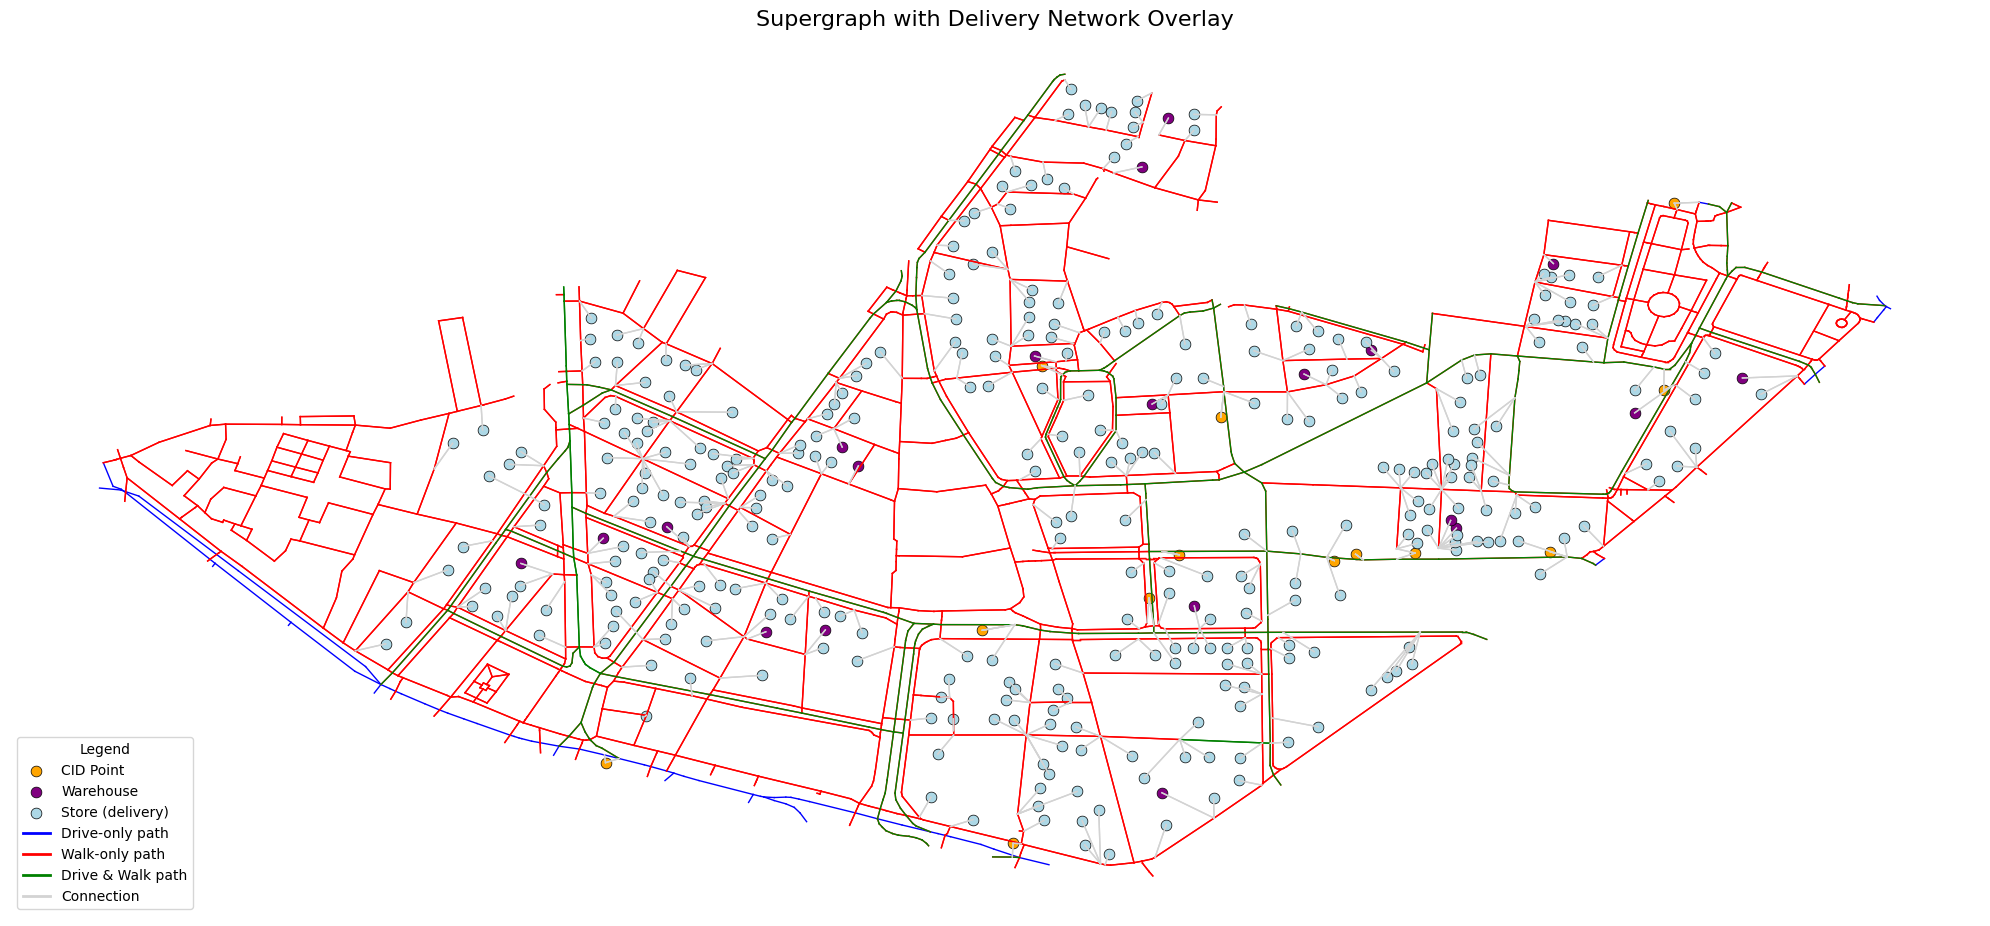

In [31]:
fig, ax = plt.subplots(figsize=(20, 20))
# Mantener proporción real en metros
ax.set_aspect('equal', 'box')

# Colores por modo de arista
edge_colors = {
    'drive': 'blue',
    'walk': 'red',
    'drive+walk': 'green',
    'connection': 'lightgray'
}

# Agrupar aristas por modo\
edges_by_mode = {mode: [] for mode in edge_colors}
for u, v, data in G_super.edges(data=True):
    modos = data.get('mode', [])
    # Determinar clave de modo, priorizando conexiones
    if isinstance(modos, list):
        if 'connection' in modos:
            mode_key = 'connection'
        elif 'drive' in modos and 'walk' in modos:
            mode_key = 'drive+walk'
        elif 'drive' in modos:
            mode_key = 'drive'
        elif 'walk' in modos:
            mode_key = 'walk'
        else:
            mode_key = 'connection'
    else:
        mode_key = modos if modos in edge_colors else 'connection'

    # Coordenadas de los nodos
    x0, y0 = G_super.nodes[u]['x'], G_super.nodes[u]['y']
    x1, y1 = G_super.nodes[v]['x'], G_super.nodes[v]['y']
    edges_by_mode[mode_key].append(((x0, x1), (y0, y1)))

# Dibujar todas las aristas
for mode_key, segments in edges_by_mode.items():
    for xs, ys in segments:
        ax.plot(xs, ys, color=edge_colors[mode_key], linewidth=1)

# Definición de categorías de nodos
categorias = {
    'cid':               {'coords': [], 'color': 'orange',     'label': 'CID Point'},
    'almacen_m3':        {'coords': [], 'color': 'purple',     'label': 'Warehouse'},
    'comercio_entrega':  {'coords': [], 'color': 'lightblue', 'label': 'Store (delivery)'},
    'almacen_y_comercio':{'coords': [], 'color': 'black',      'label': 'Warehouse & Shop'}
}

# Recolectar coordenadas de nodos especiales
for nodo, data in G_super.nodes(data=True):
    tipo = data.get('tipo')
    coord = (data['x'], data['y'])
    if tipo == 'carga':
        categorias['cid']['coords'].append(coord)
    elif tipo == 'almacen' and 'comercio' in nodo:
        categorias['almacen_y_comercio']['coords'].append(coord)
    elif tipo == 'almacen':
        categorias['almacen_m3']['coords'].append(coord)
    elif tipo == 'comercio':
        categorias['comercio_entrega']['coords'].append(coord)

# Dibujar nodos
for cat in categorias.values():
    if cat['coords']:
        xs, ys = zip(*cat['coords'])
        ax.scatter(xs, ys, color=cat['color'], s=60, edgecolor='k', linewidth=0.5, label=cat['label'])

# Crear leyenda de aristas
from matplotlib.lines import Line2D
edge_legend = [
    Line2D([0], [0], color=edge_colors[m], lw=2, label=lab)
    for m, lab in zip(
        ['drive', 'walk', 'drive+walk', 'connection'],
        ['Drive-only path', 'Walk-only path', 'Drive & Walk path', 'Connection']
    )
]

# Ajustar título y ejes
ax.set_title("Supergraph with Delivery Network Overlay", fontsize=16)
ax.axis('off')

# Combinar leyendas y eliminar duplicados
handles_nodes, labels_nodes = ax.get_legend_handles_labels()
handles = handles_nodes + edge_legend
labels = labels_nodes + [h.get_label() for h in edge_legend]
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc='lower left', title='Legend', fontsize=10)

plt.tight_layout()
plt.show()


## M1 Pipeline

### 0 Configuration

In [32]:
N_PAQUETES = 200               # Número total de paquetes a repartir
PAQUETES_MIN = 1               # Mínimo de paquetes por comercio
PAQUETES_MAX = 5               # Máximo de paquetes por comercio
CAPACIDAD_MAXIMA = 8           # Capacidad máxima que puede cargar el repartidor
VELOCIDAD_VEHICULO = 35        # Velocidad de la furgoneta en km/h si no hay en la arista max_speed
VELOCIDAD_PEATON = 5           # Velocidad del repartidor a pie en km/h
VELOCIDAD_CONEXION = 10        # Velocidad de las aristas de conexión en modo drive km/h


### 1 Deliveries sample

In [33]:
# ==============================
# Seleccionar comercios y asignar paquetes
# ==============================

paquetes_asignados = 0
bajos_seleccionados = []
paquetes_por_nodo = []

while paquetes_asignados < N_PAQUETES:
    max_pos = min(PAQUETES_MAX, N_PAQUETES - paquetes_asignados)
    if max_pos < PAQUETES_MIN: break

    nodo = random.choice(nodos_comercios)
    asignado_nodo = sum(p for nn, p in zip(bajos_seleccionados, paquetes_por_nodo) if nn == nodo)
    disponible_nodo = CAPACIDAD_MAXIMA - asignado_nodo
    if disponible_nodo < PAQUETES_MIN: continue

    paquetes = random.randint(PAQUETES_MIN, min(max_pos, disponible_nodo))
    bajos_seleccionados.append(nodo)
    paquetes_por_nodo.append(paquetes)
    paquetes_asignados += paquetes

# Agrupar y sumar por nodo 
bajos_sample = gpd.GeoDataFrame(
    pd.DataFrame([{
        'nodo': n,
        'paquetes': sum(p for nn, p in zip(bajos_seleccionados, paquetes_por_nodo) if nn == n),
        **G_super.nodes[n]
    } for n in set(bajos_seleccionados)]),
    geometry=[Point(G_super.nodes[n]['x'], G_super.nodes[n]['y']) for n in set(bajos_seleccionados)],
    crs="EPSG:4326"
)

display(bajos_sample)


nodo  paquetes         x          y      tipo  \
0   comercio_19664         5 -0.375604  39.469941  comercio   
1   comercio_17695         5 -0.378886  39.470651  comercio   
2   comercio_17693         5 -0.378423  39.470434  comercio   
3   comercio_22607         4 -0.371570  39.471960  comercio   
4   comercio_21120         3 -0.373343  39.471332  comercio   
5   comercio_20353         4 -0.374095  39.469623  comercio   
6   comercio_20354         1 -0.374033  39.469525  comercio   
7   comercio_18769         5 -0.376493  39.471933  comercio   
8   comercio_21918         6 -0.372133  39.470738  comercio   
9   comercio_20377         5 -0.374411  39.471268  comercio   
10  comercio_17124         1 -0.379041  39.470829  comercio   
11  comercio_20333         3 -0.374901  39.467943  comercio   
12  comercio_20405         5 -0.375234  39.471652  comercio   
13  comercio_18738         1 -0.377640  39.470618  comercio   
14  comercio_21106         5 -0.372882  39.468779  comercio   
15  comercio_23319         1 -0.370153  39.471473  comercio   
16  comercio_17689         5 -0.378491  39.470641  comercio   
17  comercio_17106         1 -0.379152  39.470249  comercio   
18  comercio_17102         1 -0.378739  39.469943  comercio   
19  comercio_20337         3 -0.374233  39.468714  comercio   
20  comercio_23327         5 -0.370529  39.470828  comercio   
21  comercio_21912         8 -0.372003  39.470410  comercio   
22  comercio_17115         2 -0.378884  39.471416  comercio   
23  comercio_17083         4 -0.379018  39.469594  comercio   
24  comercio_20375         2 -0.374068  39.469972  comercio   
25  comercio_20403         5 -0.375061  39.471663  comercio   
26  comercio_21885         4 -0.372286  39.470188  comercio   
27  comercio_20376         5 -0.374562  39.471552  comercio   
28  comercio_21110         1 -0.373702  39.468240  comercio   
29  comercio_19660         1 -0.375513  39.470121  comercio   
30  comercio_19674         4 -0.376352  39.471198  comercio   
31  comercio_23328         2 -0.370322  39.471091  comercio   
32  comercio_19705         3 -0.376017  39.472679  comercio   
33  comercio_19658         5 -0.375468  39.468365  comercio   
34  comercio_16406         5 -0.379880  39.469339  comercio   
35  comercio_17694         3 -0.378677  39.470552  comercio   
36  comercio_19638         5 -0.376375  39.468954  comercio   
37  comercio_21883         3 -0.373645  39.469424  comercio   
38  comercio_17679         4 -0.377920  39.469428  comercio   
39  comercio_22602         1 -0.371578  39.472138  comercio   
40  comercio_21888         3 -0.371651  39.470192  comercio   
41  comercio_23325         3 -0.370615  39.470413  comercio   
42  comercio_19677         2 -0.375878  39.470640  comercio   
43  comercio_21903         2 -0.372627  39.470242  comercio   
44  comercio_19669         2 -0.375369  39.471128  comercio   
45  comercio_18749         1 -0.377320  39.470936  comercio   
46  comercio_19641         3 -0.376026  39.468743  comercio   
47  comercio_17126         4 -0.379125  39.470725  comercio   
48  comercio_21142         5 -0.373285  39.471595  comercio   
49  comercio_20324         1 -0.374999  39.468126  comercio   
50  comercio_19634         4 -0.375765  39.467857  comercio   
51  comercio_17081         6 -0.378905  39.469757  comercio   
52  comercio_21904         4 -0.372530  39.470179  comercio   
53  comercio_20361         1 -0.374808  39.468965  comercio   
54  comercio_17097         1 -0.378561  39.470247  comercio   
55  comercio_19651         5 -0.375644  39.468892  comercio   
56  comercio_20346         1 -0.375009  39.469655  comercio   
57  comercio_19693         1 -0.375680  39.471611  comercio   
58  comercio_20365         4 -0.374212  39.469023  comercio   
59  comercio_17079         6 -0.379238  39.469868  comercio   

                     geometry  
0    POINT (-0.3756 39.46994)  
1   POINT (-0.37889 39.47065)  
2   POINT (-0.37842 39.47043)  
3   POINT (-0.37157 39.47196)  
4   POINT 

### 2 Clusters

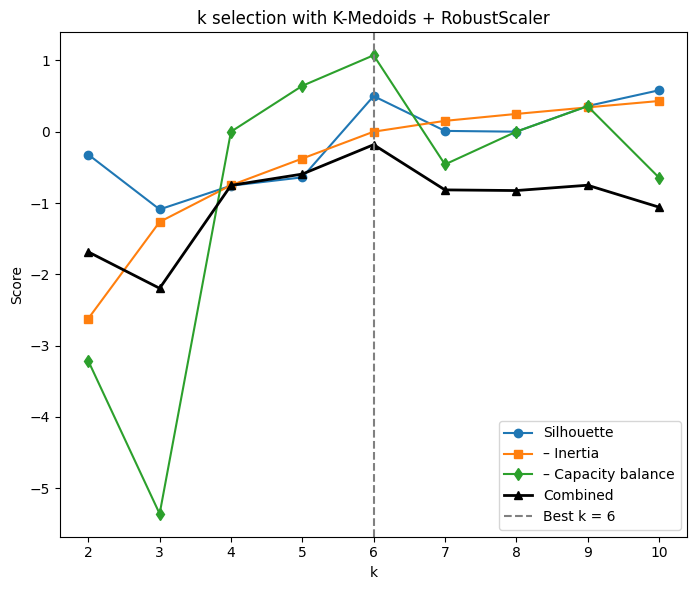

✅ Deliveries assigned to 6 couriers by K-Medoids (using coordinates of the 3 nearest CiDs).


In [34]:
import numpy as np
from scipy.spatial import cKDTree
from sklearn.metrics import silhouette_score, mean_absolute_error
from sklearn.preprocessing import RobustScaler
from sklearn_extra.cluster import KMedoids
import matplotlib.pyplot as plt

# ------------------------------
# 1) Parámetros
# ------------------------------
N_CIDS  = 3
K_MIN   = 2
K_MAX   = 10
ALPHA   = 0.3  # peso Silhouette
BETA    = 0.3  # peso Inertia
GAMMA   = 0.25  # peso Balance de capacidad
OMEGA   = 0.15  # costes fijos de un nuevo repartidor


# ------------------------------
# 2) Construir matriz de features
# ------------------------------
k_cids      = min(N_CIDS, len(nodos_carga))
cid_coords  = np.array([(G_super.nodes[c]['y'], G_super.nodes[c]['x']) for c in nodos_carga])
tree_cid    = cKDTree(cid_coords)
entrega_xy  = np.array([(pt.y, pt.x) for pt in bajos_sample.geometry])
_, indices  = tree_cid.query(entrega_xy, k=k_cids)

features = []
for i, geom in enumerate(bajos_sample.geometry):
    row = [geom.x, geom.y]
    for j in range(k_cids):
        cid = nodos_carga[indices[i][j]]
        row += [G_super.nodes[cid]['x'], G_super.nodes[cid]['y']]
    features.append(row)
features = np.array(features)

# ------------------------------
# 3) Función para seleccionar k con K-Medoids + RobustScaler
# ------------------------------
def estimate_best_k_with_kmedoids(feats, demands, cap_max,
                                  k_min=K_MIN, k_max=K_MAX,
                                  alpha=ALPHA, beta=BETA, gamma=GAMMA, omega=OMEGA):
    ks, sils, ines, balances = [], [], [], []
    for k in range(k_min, min(k_max+1, len(feats))):
        # Entrenar K-Medoids
        kmed = KMedoids(n_clusters=k, init='k-medoids++', method='pam',
                        metric='euclidean', random_state=33)
        labels = kmed.fit_predict(feats)

        # Silhouette
        sil = silhouette_score(feats, labels) if k > 1 else 0

        # Inertia manual
        medoids = feats[kmed.medoid_indices_]
        inertia = sum(
            np.sum((feats[labels==j] - medoids[j])**2)
            for j in range(k)
        )

        # Balance de capacidad (MAE vs múltiplo superior)
        loads = np.array([demands[labels==j].sum() for j in range(k)])
        mults = np.ceil(loads / cap_max) * cap_max
        bal = mean_absolute_error(loads, mults)

        ks.append(k)
        sils.append(sil)
        ines.append(inertia)
        balances.append(bal)

    # Robust scaling (resiste outliers)
    scaler = RobustScaler()
    sil_r = scaler.fit_transform(np.array(sils).reshape(-1,1)).ravel()
    # Como queremos que "mejor" sea más alto:
    ine_r = -scaler.fit_transform(np.array(ines).reshape(-1,1)).ravel()
    bal_r = -scaler.fit_transform(np.array(balances).reshape(-1,1)).ravel()

    # Score combinado
    combined = alpha * sil_r + beta * ine_r + gamma * bal_r - omega * np.arange(len(ks))
    best_k   = ks[np.argmax(combined)]

    # Gráfica de diagnóstico
    fig, ax = plt.subplots(figsize=(12,6))
    ax.set_aspect('equal', 'box')
    ax.plot(ks, sil_r, marker='o', label='Silhouette')
    ax.plot(ks, ine_r, marker='s', label='– Inertia')
    ax.plot(ks, bal_r, marker='d', label='– Capacity balance')
    ax.plot(ks, combined, marker='^', lw=2, color='black', label='Combined')
    ax.axvline(best_k, ls='--', color='gray', label=f'Best k = {best_k}')
    ax.set(xlabel='k', ylabel='Score', title='k selection with K-Medoids + RobustScaler')
    ax.legend(); plt.tight_layout(); plt.show()

    return best_k

# ------------------------------
# 4) Seleccionar k y agrupar
# ------------------------------
demands    = bajos_sample['paquetes'].to_numpy()
best_k     = estimate_best_k_with_kmedoids(features, demands, CAPACIDAD_MAXIMA)

kmed_final = KMedoids(n_clusters=best_k, init='k-medoids++',
                      method='pam', metric='euclidean', random_state=33)
labels_f   = kmed_final.fit_predict(features)
bajos_sample['grupo_repartidor'] = labels_f + 1

print(f"✅ Deliveries assigned to {best_k} couriers by K-Medoids (using coordinates of the {k_cids} nearest CiDs).")


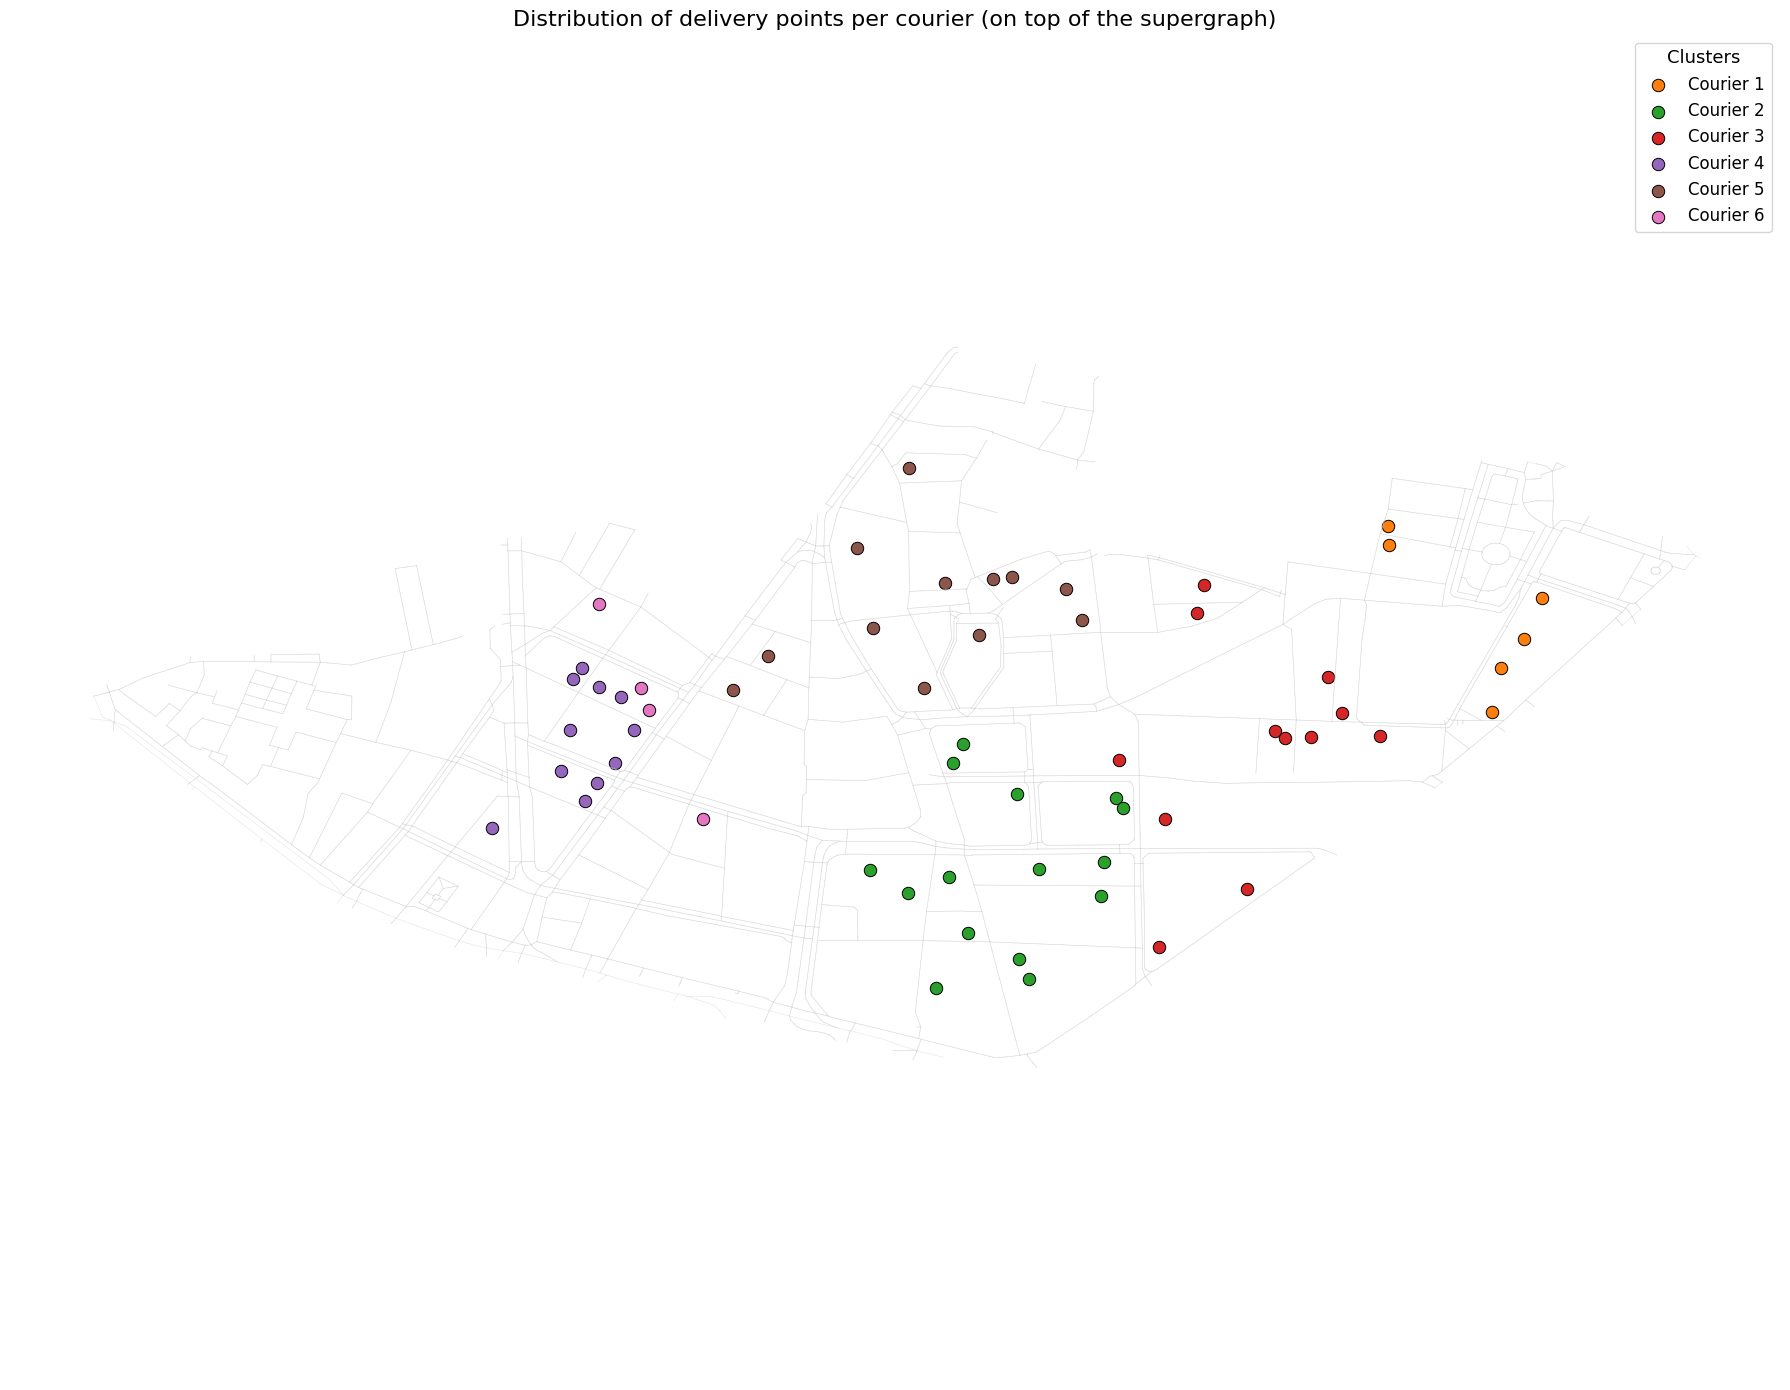

In [35]:
fig, ax = plt.subplots(figsize=(18, 14))
ax.set_aspect('equal', 'box')

# 1. Draw the edges of the supergraph (all streets)
for u, v, data in G_super.edges(data=True):
    if isinstance(u, str) or isinstance(v, str):
        continue
    x0, y0 = G_super.nodes[u]['x'], G_super.nodes[u]['y']
    x1, y1 = G_super.nodes[v]['x'], G_super.nodes[v]['y']
    ax.plot([x0, x1], [y0, y1], color='lightgray', linewidth=0.4, alpha=0.6)

# 2. Plot delivery points grouped by cluster
colors = list(mcolors.TABLEAU_COLORS.values()) + list(mcolors.CSS4_COLORS.values())

for group in sorted(bajos_sample['grupo_repartidor'].unique()):
    group_deliveries = bajos_sample[bajos_sample['grupo_repartidor'] == group]
    xs = group_deliveries.geometry.x
    ys = group_deliveries.geometry.y
    ax.scatter(xs, ys, label=f'Courier {group}', s=80, color=colors[group % len(colors)], edgecolor='black', linewidth=0.7)

# 3. General plot style
ax.set_title("Distribution of delivery points per courier (on top of the supergraph)", fontsize=16)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.axis('equal')
ax.axis('off')
ax.legend(title="Clusters", fontsize=12, title_fontsize=13)

plt.tight_layout()
plt.show()


### 3 Routing

In [36]:
# ==============================
# 1. FUNCIONES DE TIEMPO
# ==============================
def tiempo_por_distancia(distancia_metros, velocidad_kmh):
    """Convierte distancia en metros y velocidad en km/h a tiempo en minutos."""
    return distancia_metros / (velocidad_kmh * 1000 / 60)


def calcular_tiempos_en_aristas(G, VELOCIDAD_PEATON=5, VELOCIDAD_VEHICULO=35, VELOCIDAD_CONNECTION=10):
    """
    Añade a cada arista del grafo G los tiempos de caminata (tiempo_walk)
    y de conducción (tiempo_drive) según su modo ('walk','drive','connection') de distribuciones normales.
    """

    v_peaton = np.random.normal(VELOCIDAD_PEATON, 0.2 * VELOCIDAD_PEATON, size=30)
    v_connection = np.random.normal(VELOCIDAD_CONNECTION, 0.2 * VELOCIDAD_CONNECTION, size=30)
    v_vehiculo = np.random.normal(VELOCIDAD_VEHICULO, 0.2 * VELOCIDAD_VEHICULO, size=30)

    for u, v, k, data in G.edges(keys=True, data=True):
        d = data.get('length', 100)
        modos = data.get('mode', ['walk'])

        if 'connection' in modos:
            data['tiempo_walk'] = tiempo_por_distancia(d, np.random.choice(v_peaton))
            data['tiempo_drive'] = tiempo_por_distancia(d, np.random.choice(v_connection))
            continue

        if 'walk' in modos:
            data['tiempo_walk'] = tiempo_por_distancia(d, np.random.choice(v_peaton))

        if 'drive' in modos:
            v_max = data.get('maxspeed', np.random.choice(v_vehiculo))
            if isinstance(v_max, str):
                v_max = int(''.join(filter(str.isdigit, v_max)) or 30)
            v_kmh = max(v_max * 0.5, np.random.normal(v_max * 0.8, v_max * 0.1))
            data['tiempo_drive'] = tiempo_por_distancia(d, v_kmh)

        data.setdefault('tiempo_walk', float('inf'))
        data.setdefault('tiempo_drive', float('inf'))


def calcular_tiempo_drive(origen, destino):
    """Ruta más rápida en vehículo entre origen y destino (minutos)."""
    try:
        camino = nx.shortest_path(G_super, origen, destino, weight='tiempo_drive')
    except nx.NetworkXNoPath:
        return float('inf'), None
    tiempo = 0.0
    for u, v in zip(camino[:-1], camino[1:]):
        ed    = G_super.get_edge_data(u, v)
        t_min = min(e['tiempo_drive'] for e in ed.values())
        tiempo += t_min
    return tiempo, camino

def calcular_tiempo_walk(origen, destino):
    """Ruta más rápida a pie entre origen y destino (minutos)."""
    try:
        camino = nx.shortest_path(G_super, origen, destino, weight='tiempo_walk')
    except nx.NetworkXNoPath:
        return float('inf'), None
    tiempo = 0.0
    for u, v in zip(camino[:-1], camino[1:]):
        ed    = G_super.get_edge_data(u, v)
        t_min = min(e['tiempo_walk'] for e in ed.values())
        tiempo += t_min
    return tiempo, camino

# ==============================
# 2. FUNCIONES AUXILIARES
# ==============================
def obtener_centroide_grupo(df_grupo):
    """Centroide geográfico de un DataFrame de geometrías."""
    return df_grupo.geometry.union_all().centroid

def distancia_euclidea(x1, y1, x2, y2):
    """Distancia euclídea en 2D."""
    return np.hypot(x1 - x2, y1 - y2)

def nodo_cid_mas_cercano(geom, nodos_cid):
    """Nodo CiD más cercano por distancia euclídea."""
    coords = [(G_super.nodes[n]['y'], G_super.nodes[n]['x']) for n in nodos_cid]
    tree   = cKDTree(coords)
    _, idx = tree.query((geom.y, geom.x))
    return nodos_cid[idx]

def calcular_matriz_distancias(pendientes, nodo_cid):
    """
    Matriz de distancias a pie entre todos los nodos pendientes + nodo CiD.
    """
    distancias = {}
    puntos     = pendientes['nodo'].tolist() + [nodo_cid]
    for n1 in puntos:
        distancias[n1] = {}
        for n2 in puntos:
            if n1 == n2:
                continue
            t, _ = calcular_tiempo_walk(n1, n2)
            distancias[n1][n2] = t
    return distancias

# ==============================
# 3. INICIALIZACIÓN
# ==============================
calcular_tiempos_en_aristas(G_super)

rutas_y_tiempos   = []
inicios_furgoneta = []
grupos_pendientes = set(bajos_sample['grupo_repartidor'].unique())
centroides_grupos = {
    g: obtener_centroide_grupo(bajos_sample[bajos_sample['grupo_repartidor']==g])
    for g in grupos_pendientes
}

total_walk_distance = total_drive_distance = 0.0
# parámetro inicial para node-boundary
thresh = 0.00005

# contadores globales
tiempo_total_total = tiempo_drive_total = tiempo_walk_total = 0.0

# ==============================
# 4. RECORRIDO POR CADA CLÚSTER
# ==============================
while grupos_pendientes:
    # recalcular boundary_nodes con el umbral actual
    boundary_nodes = [
        n for n,d in G_drive.nodes(data=True)
        if shp_zone.boundary.distance(Point(d['x'], d['y'])) < thresh
    ]
    if len(boundary_nodes) < 8:
        if thresh < 0.1:
            thresh = min(thresh * 3, 0.1)
            continue
        else:
            raise RuntimeError("No se encontró entrada válida para los clústeres restantes.")
        
    random.shuffle(boundary_nodes)

    # intentar encontrar entrada válida; si falla, aumentar thresh hasta 0.05
    entry_info = None
    for bnd in boundary_nodes:
        # elegir clúster más cercano por euclídea
        g_cand = min(
            grupos_pendientes,
            key=lambda g: distancia_euclidea(
                G_super.nodes[bnd]['x'], G_super.nodes[bnd]['y'],
                centroides_grupos[g].x, centroides_grupos[g].y
            )
        )
        cid_cand = nodo_cid_mas_cercano(centroides_grupos[g_cand], nodos_carga)
        t_drive, camino = calcular_tiempo_drive(bnd, cid_cand)
        if camino and np.isfinite(t_drive):
            entry_info = (bnd, g_cand, cid_cand, camino[1:], t_drive)
            break

    if entry_info is None:
        # si no encontramos y aún podemos aumentar thresh
        if thresh < 0.1:
            thresh = min(thresh * 3, 0.1)
            continue
        else:
            raise RuntimeError("No se encontró entrada válida para los clústeres restantes.")

    # desempaquetar entrada válida
    entry, grupo_sel, nodo_cid, ruta_drive, tiempo_drive = entry_info
    inicios_furgoneta.append(entry)
    dist_furgo = sum(
            G_super.get_edge_data(u,v)[0]['length']
            for u,v in zip(camino[:-1], camino[1:])
        )
    total_drive_distance += dist_furgo
    tiempo_drive_total += tiempo_drive

    # preparativos para entregas a pie
    sub_bajos  = bajos_sample[bajos_sample['grupo_repartidor']==grupo_sel]
    pendientes = sub_bajos.copy()
    nodo_actual = nodo_cid
    carga_actual = 0
    rutas_walk   = []
    tiempos_walk = []
    tiempo_walk_cluster = 0.0

    matriz_dist = calcular_matriz_distancias(pendientes, nodo_cid)

    # nearest‐neighbor greedy + recarga
    while not pendientes.empty:
        dist_map = { n: matriz_dist[nodo_actual][n] for n in pendientes['nodo'] }
        nodo_sig = min(dist_map, key=dist_map.get)
        pkgs     = pendientes.loc[pendientes['nodo']==nodo_sig, 'paquetes'].item()

        # recargar si excede capacidad
        if carga_actual + pkgs > CAPACIDAD_MAXIMA:
            t_back, camino_back = calcular_tiempo_walk(nodo_actual, nodo_cid)
            dist_back = sum(
                G_super.get_edge_data(u,v)[0]['length']
                for u,v in zip(camino_back[:-1], camino_back[1:])
            )
            tiempo_walk_cluster += t_back
            rutas_walk[-1] = rutas_walk[-1] + camino_back[1:]
            nodo_actual = nodo_cid
            carga_actual = 0
            total_walk_distance += dist_back
            continue

        # entrega
        t_ida, camino_ida = calcular_tiempo_walk(nodo_actual, nodo_sig)
        dist_ida = sum(
            G_super.get_edge_data(u,v)[0]['length']
            for u,v in zip(camino_ida[:-1], camino_ida[1:])
        )
        tiempo_entrega = np.random.normal(loc=1, scale=0.2)
        tiempo_walk_cluster += t_ida + tiempo_entrega
        rutas_walk.append(camino_ida[1:])
        tiempos_walk.append(tiempo_walk_cluster)
        total_walk_distance += dist_ida

        carga_actual += pkgs
        pendientes = pendientes[pendientes['nodo']!=nodo_sig]
        nodo_actual = nodo_sig

    # almacenar resultados
    rutas_y_tiempos.append({
        'grupo_repartidor': grupo_sel,
        'ruta_furgoneta':   ruta_drive,
        'tiempo_drive':     tiempo_drive,
        'tiempo_walk':      tiempo_walk_cluster,
        'rutas_walk':       rutas_walk,
        'tiempos_walk':     tiempos_walk
    })

    tiempo_total_total += tiempo_drive + tiempo_walk_cluster
    tiempo_walk_total  += tiempo_walk_cluster
    grupos_pendientes.remove(grupo_sel)

# ==============================
# 5. RESULTADOS FINALES
# ==============================
df_rutas_y_tiempos = pd.DataFrame(rutas_y_tiempos)
# Mostrar el orden de los grupos de entrega, tiempos y detalle de comercios visitados
print("\n📦  DELIVERY SUMMARY  📦")
print("=" * 30)

for idx, row in df_rutas_y_tiempos.iterrows():
    grupo        = row['grupo_repartidor']
    tiempo_drive = row['tiempo_drive']
    tiempo_walk  = row['tiempo_walk']
    rutas_walk   = row['rutas_walk']
    tiempos_walk = row['tiempos_walk']

    # Encabezado de clúster
    print(f"\n🚚  CLUSTER {grupo}")
    print(f"• Drive time : {tiempo_drive:6.2f} min")
    print(f"• Walk time  : {tiempo_walk:6.2f} min")

    # Preparamos la secuencia de entregas (solo los tramos de ida)
    entregas_paths = rutas_walk[0::2]

    # Imprimimos la tabla con tiempos de llegada
    print("\n   📍  Delivery sequence:")
    print("     No. |       Node        | Packages | Arrival (min)")
    print("     ----+-------------------+----------+---------------")

    cumulative_walk = 0.0
    for i, path in enumerate(entregas_paths, start=1):
        for n in path:
            if 'comercio' in str(n):
                comercio = n
                break
        pkgs     = bajos_sample.loc[bajos_sample['nodo']==comercio, 'paquetes'].iat[0]

        # El índice en tiempos_walk para el tramo de ida es (i-1)*2
        idx_walk = (i - 1) * 2
        t_ida    = tiempos_walk[idx_walk]
        cumulative_walk += t_ida

        # Tiempo de llegada = tiempo de drive + tiempo acumulado de walk
        arrival_time = tiempo_drive + cumulative_walk

        print(f"     {i:>3}  | {comercio:<17} | {pkgs:^8} | {arrival_time:>13.2f}")

    print("-" * 65)
print("\n===📦 OVERALL RESULTS 📦===")
print(f"⏱️ Total delivery: {tiempo_total_total:.1f} min ({total_walk_distance+total_drive_distance:.1f} m)")
print(f"🚐 Total driving: {tiempo_drive_total:.1f} min ({total_drive_distance:.1f} m)")
print(f"🚶‍♂️ Total walking: {tiempo_walk_total:.1f} min ({total_walk_distance:.1f} m)\n")




📦  DELIVERY SUMMARY  📦

🚚  CLUSTER 4
• Drive time :   2.09 min
• Walk time  :  61.47 min

   📍  Delivery sequence:
     No. |       Node        | Packages | Arrival (min)
     ----+-------------------+----------+---------------
       1  | comercio_17083    |    4     |          5.35
       2  | comercio_17102    |    1     |         16.13
       3  | comercio_16406    |    5     |         36.92
       4  | comercio_17106    |    1     |         67.28
       5  | comercio_17695    |    5     |        116.83
       6  | comercio_17124    |    1     |        178.30
-----------------------------------------------------------------

🚚  CLUSTER 5
• Drive time :   1.06 min
• Walk time  :  44.32 min

   📍  Delivery sequence:
     No. |       Node        | Packages | Arrival (min)
     ----+-------------------+----------+---------------
       1  | comercio_19693    |    1     |          2.88
       2  | comercio_19669    |    2     |          9.53
       3  | comercio_19674    |    4     |  

### 4 Results mapping

In [37]:
# ==============================
# 1. COLORES POR CLÚSTER
# ==============================
cluster_ids    = sorted(bajos_sample['grupo_repartidor'].unique())
base_colors    = list(mcolors.TABLEAU_COLORS.values())
cluster_colors = {cid: base_colors[i % len(base_colors)] for i, cid in enumerate(cluster_ids)}

# ==============================
# (Re)compute order_map
# ==============================
order_map = {}
for _, row in df_rutas_y_tiempos.iterrows():
    grp        = row['grupo_repartidor']
    rutas_walk = row['rutas_walk']
    order_map[grp] = { path[-1]: idx for idx, path in enumerate(rutas_walk, start=1) }

# ==============================
# 2. PREPARAR MARCADORES AGRUPADOS
# ==============================
items = []
for nodo, data in G_super.nodes(data=True):
    if nodo in set(bajos_sample['nodo']):
        grp   = bajos_sample.loc[bajos_sample['nodo']==nodo, 'grupo_repartidor'].iat[0]
        pkgs  = bajos_sample.loc[bajos_sample['nodo']==nodo, 'paquetes'].iat[0]
        order = order_map[grp].get(nodo)  # now defined
        items.append((data['y'], data['x'], 'comercio', nodo, grp, pkgs, order))

cluster_to_cid = {
    row['grupo_repartidor']: row['ruta_furgoneta'][-1]
    for _, row in df_rutas_y_tiempos.iterrows() if row['ruta_furgoneta']
}
for grp, cid in cluster_to_cid.items():
    y, x = G_super.nodes[cid]['y'], G_super.nodes[cid]['x']
    items.append((y, x, 'cid', cid, grp, None, None))

loc_groups = defaultdict(list)
for it in items:
    loc = (round(it[0], 6), round(it[1], 6))
    loc_groups[loc].append(it)

# ==============================
# 3. CREAR MAPA
# ==============================
centro_mapa = [
    np.mean([d['y'] for _, d in G_super.nodes(data=True)]),
    np.mean([d['x'] for _, d in G_super.nodes(data=True)])
]
m = folium.Map(location=centro_mapa, zoom_start=16, tiles="cartodb positron")
GeoJson(
    shp_zone,
    style_function=lambda f: {"color":"green","weight":6,"fill":True,"fillColor":"limegreen","fillOpacity":0.1}
).add_to(m)

# ==============================
# 4. MARCAR NODOS Y CÍRCULOS DE GRUPO
# ==============================
RADIUS_METERS = 7
for (lat0, lon0), group in loc_groups.items():
    n = len(group)
    if n > 1:
        folium.Circle(
            location=(lat0, lon0),
            radius=RADIUS_METERS,
            color="black", weight=1,
            fill=True, fill_color="black", fill_opacity=0.2
        ).add_to(m)
    for idx, (lat, lon, tipo, nodo, grp, pkgs, order) in enumerate(group):
        color = cluster_colors[grp]
        if n == 1:
            lat_j, lon_j = lat, lon
        else:
            angle = 2 * math.pi * idx / n
            dlat  = (RADIUS_METERS * math.cos(angle)) / 111000
            dlon  = (RADIUS_METERS * math.sin(angle)) / (111000 * math.cos(math.radians(lat0)))
            lat_j, lon_j = lat0 + dlat, lon0 + dlon

        if tipo == 'comercio':
            CircleMarker(
                location=(lat_j, lon_j), radius=8,
                color=color, fill=True, fill_opacity=0.7
            ).add_to(m)
            if order:
                Marker(
                    location=(lat_j, lon_j),
                    icon=DivIcon(
                        icon_size=(20,20),
                        html=(
                            f"<div style='font-size:12px;color:white;"
                            f"background:{color};border-radius:50%;"
                            f"width:20px;height:20px;line-height:20px;text-align:center;'>"
                            f"{order}</div>"
                        )
                    )
                ).add_to(m)
        else:  # CiD
            Marker(
                location=(lat_j, lon_j),
                icon=Icon(color="white", icon_color=color, icon="truck", prefix="fa"),
                popup=f"CiD Cluster {grp}"
            ).add_to(m)

# ==============================
# 5. RUTAS Y PUNTOS DE ENTRADA CON CLUSTERING
# ==============================
entry_cluster = MarkerCluster(name="Truck start points").add_to(m)

for _, row in df_rutas_y_tiempos.iterrows():
    grp        = row['grupo_repartidor']
    color      = cluster_colors[grp]
    ruta_drive = row['ruta_furgoneta']

    # 5.1 – Inicio furgoneta
    if ruta_drive:
        inicio = ruta_drive[0]
        y0, x0 = G_super.nodes[inicio]['y'], G_super.nodes[inicio]['x']
        Marker(
            location=(y0, x0),
            icon=DivIcon(
                icon_size=(25,25),
                html=(
                    f"<div style='"
                    f"width:25px;height:25px;"
                    f"background:{color};"
                    f"border:3px solid black;"        # <-- black circumference
                    f"border-radius:50%;"
                    f"display:flex;align-items:center;"
                    f"justify-content:center;"
                    f"color:#fff;font-weight:bold;"
                    f"font-size:14px;"
                    f"'>"
                    f"{grp}"
                    f"</div>"
                )
            ),
            popup=f"Truck start for cluster {grp}"
        ).add_to(entry_cluster)

    # 5.2 – Línea furgoneta
    coords_d = [(G_super.nodes[n]['y'], G_super.nodes[n]['x']) for n in ruta_drive]
    if coords_d:
        PolyLine(coords_d, color=color, weight=4, opacity=0.5).add_to(m)

    # 5.3 – Caminata
    for caminata in row['rutas_walk']:
        coords_w = [(G_super.nodes[n]['y'], G_super.nodes[n]['x']) for n in caminata]
        PolyLine(coords_w, color=color, weight=2, opacity=0.5, dash_array="4,20").add_to(m)

# ==============================
# 6. MOSTRAR MAPA
# ==============================
m


### 5 Economic costs

In [38]:
# Datos de entrada
coste_por_hora = 21.19          # €/hora
coste_por_km_drive = 0.184      # €/km
coste_fijo_diario = 31.76       # €/furgoneta por misión

# Datos de resultados de tu simulación
tiempo_total_min = tiempo_total_total          # minutos
distancia_drive_m = total_drive_distance       # metros
numero_clusters = len(df_rutas_y_tiempos)       # número de clusters = número de furgonetas usadas

# Conversión
tiempo_total_horas = tiempo_total_min / 60
distancia_drive_km = distancia_drive_m / 1000

# Costes
coste_tiempo_total = tiempo_total_horas * coste_por_hora
coste_km_total = distancia_drive_km * coste_por_km_drive
coste_fijo_total = numero_clusters * coste_fijo_diario

# Coste total
coste_total_operacion = coste_tiempo_total + coste_km_total + coste_fijo_total

print(f"🕒 Coste por tiempo total: {coste_tiempo_total:.2f} €")
print(f"🛣️ Coste por km conducidos: {coste_km_total:.2f} €")
print(f"🚐 Coste fijo por furgonetas: {coste_fijo_total:.2f} €")
print(f"💥 COSTE ECONÓMICO TOTAL: {coste_total_operacion:.2f} €")


🕒 Coste por tiempo total: 97.68 €
🛣️ Coste por km conducidos: 0.51 €
🚐 Coste fijo por furgonetas: 190.56 €
💥 COSTE ECONÓMICO TOTAL: 288.75 €


In [39]:
import pandas as pd

# Costes
coste_por_hora = 21.19          # €/hora
coste_por_km_drive = 0.184      # €/km
coste_fijo_diario = 31.76       # €/furgoneta por misión

# Datos de operación
n_clusters = len(df_rutas_y_tiempos)
total_tiempo_min = tiempo_total_total
total_drive_min = tiempo_drive_total
total_walk_min = tiempo_walk_total
total_drive_m = total_drive_distance
total_walk_m = total_walk_distance
total_distancia_m = total_drive_m + total_walk_m

# Costes
coste_tiempo_eur = (total_tiempo_min / 60) * coste_por_hora
coste_drive_eur = (total_drive_m / 1000) * coste_por_km_drive
coste_fijo_eur = n_clusters * coste_fijo_diario
coste_total_eur = coste_tiempo_eur + coste_drive_eur + coste_fijo_eur

# Número de paquetes
n_paquetes = bajos_sample['paquetes'].sum()

# Barrio
# (asumo que tienes la variable `barrio` definida en tu contexto)
# Si no, ponlo manualmente como string
barrio_nombre = barrio

# Construir el DataFrame final
df_resultados = pd.DataFrame([{
    'barrio': barrio_nombre,
    'n_paquetes': n_paquetes,
    'n_clusters': n_clusters,
    'total_tiempo_min': total_tiempo_min,
    'total_drive_min': total_drive_min,
    'total_walk_min': total_walk_min,
    'total_drive_m': total_drive_m,
    'total_walk_m': total_walk_m,
    'total_distancia_m': total_distancia_m,
    'coste_tiempo_eur': coste_tiempo_eur,
    'coste_drive_eur': coste_drive_eur,
    'coste_fijo_eur': coste_fijo_eur,
    'coste_total_eur': coste_total_eur
}])

# Mostrar el resultado
df_resultados = df_resultados.round(2)
df_resultados

barrio  n_paquetes  n_clusters  total_tiempo_min  total_drive_min  \
0  SANT FRANCESC         200           6            276.57             6.96   

   total_walk_min  total_drive_m  total_walk_m  total_distancia_m  \
0          269.61         2798.2      16991.28           19789.48   

   coste_tiempo_eur  coste_drive_eur  coste_fijo_eur  coste_total_eur  
0             97.68             0.51          190.56           288.75